# Naive Bayes Fake News Classifier

Este notebook implementa um classificador Naive Bayes para detectar notícias falsas usando o dataset FakeBr News.

## Objetivo
Criar um modelo Naive Bayes que classifique notícias como verdadeiras ou falsas baseado no texto pré-processado (`preprocessed_text`).

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carregamento dos Dados

In [2]:
# Carregar dados do parquet
df = pd.read_parquet('../data/processed/fakebr_news.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nColunas disponíveis: {df.columns.tolist()}")
print(f"\nDistribuição de classes:")
print(df['is_fake'].value_counts())
print(f"\nPorcentagem:")
print(df['is_fake'].value_counts(normalize=True) * 100)

Dataset shape: (7200, 31)

Colunas disponíveis: ['id', 'full_text', 'preprocessed_text', 'size_normalized_text', 'author', 'link', 'category', 'publication_date', 'is_fake', 'text_hash', 'created_at', 'updated_at', 'num_tokens', 'num_palavras_sem_pontuacao', 'num_tipos', 'num_links_internos', 'num_palavras_maiuscula', 'num_verbos', 'num_nomes', 'num_adjetivos', 'num_adverbios', 'num_pronomes', 'num_caracteres', 'avg_sent_length', 'avg_word_length', 'pausality', 'emotiveness', 'diversity', 'percentage_spelling_errors', 'publication_date_as_date', 'sequence']

Distribuição de classes:
is_fake
True     3600
False    3600
Name: count, dtype: int64

Porcentagem:
is_fake
True     50.0
False    50.0
Name: proportion, dtype: float64


In [18]:
# Verificar dados faltantes no preprocessed_text
print(f"Valores nulos em preprocessed_text: {df['preprocessed_text'].isnull().sum()}")
print(f"Valores vazios em preprocessed_text: {(df['preprocessed_text'] == '').sum()}")

# Remover linhas com texto vazio ou nulo
df_clean = df[df['preprocessed_text'].notna() & (df['preprocessed_text'] != '')].copy()
print(f"\nDataset após limpeza: {df_clean.shape}")

Valores nulos em preprocessed_text: 0
Valores vazios em preprocessed_text: 0

Dataset após limpeza: (7200, 31)


## 2. Preparação dos Dados

In [19]:
# Separar features (X) e target (y)
X = df_clean['preprocessed_text'].values
y = df_clean['is_fake'].values.astype(int)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribuição de y:")
print(f"Fake (1): {y.sum()} ({y.sum()/len(y)*100:.2f}%)")
print(f"True (0): {len(y) - y.sum()} ({(len(y) - y.sum())/len(y)*100:.2f}%)")

Shape de X: (7200,)
Shape de y: (7200,)

Distribuição de y:
Fake (1): 3600 (50.00%)
True (0): 3600 (50.00%)


In [20]:
# Split estratificado mantendo os pares juntos
unique_sequences = df_clean['sequence'].unique()
train_sequences, test_sequences = train_test_split(
    unique_sequences, 
    test_size=0.2, 
    random_state=42
)

# Criar máscaras para train e test
train_mask = df_clean['sequence'].isin(train_sequences)
test_mask = df_clean['sequence'].isin(test_sequences)

X_train = df_clean[train_mask]['preprocessed_text'].values
X_test = df_clean[test_mask]['preprocessed_text'].values
y_train = df_clean[train_mask]['is_fake'].values.astype(int)
y_test = df_clean[test_mask]['is_fake'].values.astype(int)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"\nDistribuição no treino - Fake: {y_train.sum()}, True: {len(y_train) - y_train.sum()}")
print(f"Distribuição no teste - Fake: {y_test.sum()}, True: {len(y_test) - y_test.sum()}")

Tamanho do conjunto de treino: 5760
Tamanho do conjunto de teste: 1440

Distribuição no treino - Fake: 2880, True: 2880
Distribuição no teste - Fake: 720, True: 720


## 3. Vetorização do Texto (TF-IDF)

In [21]:
# Criar vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit e transform no conjunto de treino
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape de X_test_tfidf: {X_test_tfidf.shape}")
print(f"\nNúmero de features: {len(tfidf.get_feature_names_out())}")

Shape de X_train_tfidf: (5760, 5000)
Shape de X_test_tfidf: (1440, 5000)

Número de features: 5000


## 4. Treinamento do Naive Bayes

### 4.1 Modelo Baseline (Multinomial NB)

In [22]:
# Treinar Multinomial Naive Bayes baseline
print("Treinando Multinomial Naive Bayes baseline...")
mnb_baseline = MultinomialNB()
mnb_baseline.fit(X_train_tfidf, y_train)

# Predições
y_pred_train = mnb_baseline.predict(X_train_tfidf)
y_pred_test = mnb_baseline.predict(X_test_tfidf)

# Avaliação
print("\n=== Resultados Multinomial NB Baseline ===")
print(f"Acurácia no treino: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_test):.4f}")

print("\nClassification Report (Teste):")
print(classification_report(y_test, y_pred_test, target_names=['True News', 'Fake News']))

Treinando Multinomial Naive Bayes baseline...

=== Resultados Multinomial NB Baseline ===
Acurácia no treino: 0.9101
Acurácia no teste: 0.8639
F1-Score no teste: 0.8584

Classification Report (Teste):
              precision    recall  f1-score   support

   True News       0.84      0.90      0.87       720
   Fake News       0.89      0.82      0.86       720

    accuracy                           0.86      1440
   macro avg       0.87      0.86      0.86      1440
weighted avg       0.87      0.86      0.86      1440



### 4.2 Complement Naive Bayes

In [23]:
# Treinar Complement Naive Bayes
print("Treinando Complement Naive Bayes...")
cnb = ComplementNB()
cnb.fit(X_train_tfidf, y_train)

# Predições
y_pred_train_cnb = cnb.predict(X_train_tfidf)
y_pred_test_cnb = cnb.predict(X_test_tfidf)

# Avaliação
print("\n=== Resultados Complement NB ===")
print(f"Acurácia no treino: {accuracy_score(y_train, y_pred_train_cnb):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_test_cnb):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_test_cnb):.4f}")

print("\nClassification Report (Teste):")
print(classification_report(y_test, y_pred_test_cnb, target_names=['True News', 'Fake News']))

Treinando Complement Naive Bayes...

=== Resultados Complement NB ===
Acurácia no treino: 0.9101
Acurácia no teste: 0.8639
F1-Score no teste: 0.8584

Classification Report (Teste):
              precision    recall  f1-score   support

   True News       0.84      0.90      0.87       720
   Fake News       0.89      0.82      0.86       720

    accuracy                           0.86      1440
   macro avg       0.87      0.86      0.86      1440
weighted avg       0.87      0.86      0.86      1440



### 4.3 Otimização de Hiperparâmetros

In [27]:
# Grid Search para Multinomial NB
print("Executando Grid Search para Multinomial NB...")
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train_tfidf, y_train)

print(f"\nMelhores parâmetros: {grid_search.best_params_}")
print(f"Melhor F1-Score (CV): {grid_search.best_score_:.4f}")

# Usar o melhor modelo
best_nb = grid_search.best_estimator_
y_pred_best = best_nb.predict(X_test_tfidf)

print("\n=== Resultados do Melhor Modelo ===")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['True News', 'Fake News']))

Executando Grid Search para Multinomial NB...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.0s
[C

## 5. Visualização dos Resultados

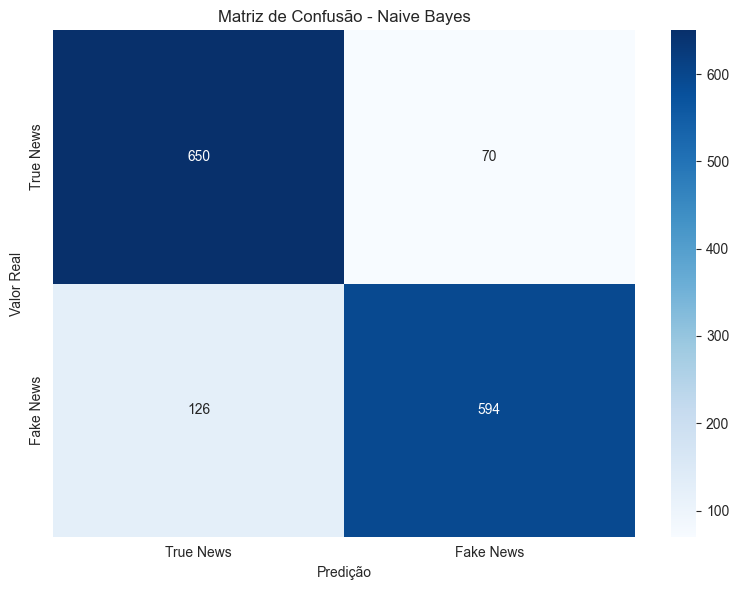


Métricas da Matriz de Confusão:
True Negatives (TN): 650
False Positives (FP): 70
False Negatives (FN): 126
True Positives (TP): 594

Precisão: 0.8946
Recall: 0.8250


In [28]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['True News', 'Fake News'],
            yticklabels=['True News', 'Fake News'])
plt.title('Matriz de Confusão - Naive Bayes')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.show()

# Calcular métricas da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print(f"\nMétricas da Matriz de Confusão:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nPrecisão: {tp/(tp+fp):.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")


Comparação de Modelos:
               Modelo  Acurácia  F1-Score
       Multinomial NB  0.863889  0.858382
        Complement NB  0.863889  0.858382
Best NB (Grid Search)  0.863889  0.858382


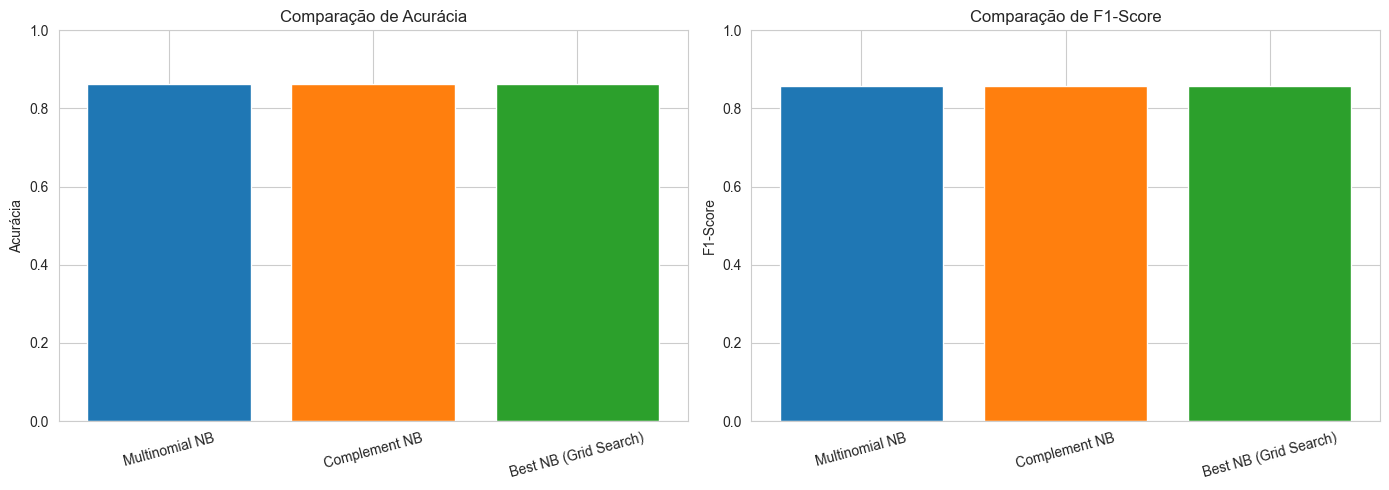

In [29]:
# Comparação de modelos
models_comparison = pd.DataFrame({
    'Modelo': ['Multinomial NB', 'Complement NB', 'Best NB (Grid Search)'],
    'Acurácia': [
        accuracy_score(y_test, y_pred_test),
        accuracy_score(y_test, y_pred_test_cnb),
        accuracy_score(y_test, y_pred_best)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test_cnb),
        f1_score(y_test, y_pred_best)
    ]
})

print("\nComparação de Modelos:")
print(models_comparison.to_string(index=False))

# Gráfico de comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Acurácia
axes[0].bar(models_comparison['Modelo'], models_comparison['Acurácia'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Comparação de Acurácia')
axes[0].set_ylabel('Acurácia')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=15)

# F1-Score
axes[1].bar(models_comparison['Modelo'], models_comparison['F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Comparação de F1-Score')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## 6. Análise de Features Importantes

In [30]:
# Obter log probabilities das features
feature_names = tfidf.get_feature_names_out()
feature_log_prob = best_nb.feature_log_prob_

# Calcular diferença entre classes (Fake - True)
feature_importance = feature_log_prob[1] - feature_log_prob[0]

# Top 20 features mais importantes para FAKE news
top_fake_indices = np.argsort(feature_importance)[-20:]
top_fake_features = [(feature_names[i], feature_importance[i]) for i in top_fake_indices]

print("Top 20 Features para FAKE News:")
for feature, score in reversed(top_fake_features):
    print(f"{feature:30s}: {score:.4f}")

# Top 20 features mais importantes para TRUE news
top_true_indices = np.argsort(feature_importance)[:20]
top_true_features = [(feature_names[i], feature_importance[i]) for i in top_true_indices]

print("\nTop 20 Features para TRUE News:")
for feature, score in top_true_features:
    print(f"{feature:30s}: {score:.4f}")

Top 20 Features para FAKE News:
diario brasil                 : 3.1007
leia tambem                   : 2.9142
antagonista                   : 2.6490
jon                           : 2.4483
rede globo                    : 2.1135
uol                           : 2.0388
internautas                   : 1.9760
presidenta                    : 1.8820
portal                        : 1.8735
moca                          : 1.8651
fatima                        : 1.8562
friboi                        : 1.8454
ditador                       : 1.8263
corruptos                     : 1.8111
corrupto                      : 1.7365
recado                        : 1.7008
apresentador                  : 1.6956
ladrao                        : 1.6915
pau                           : 1.6654
dilma nao                     : 1.6530

Top 20 Features para TRUE News:
nesta quarta                  : -1.8241
g1                            : -1.7496
nesta terca                   : -1.7426
eldorado                      : -1.

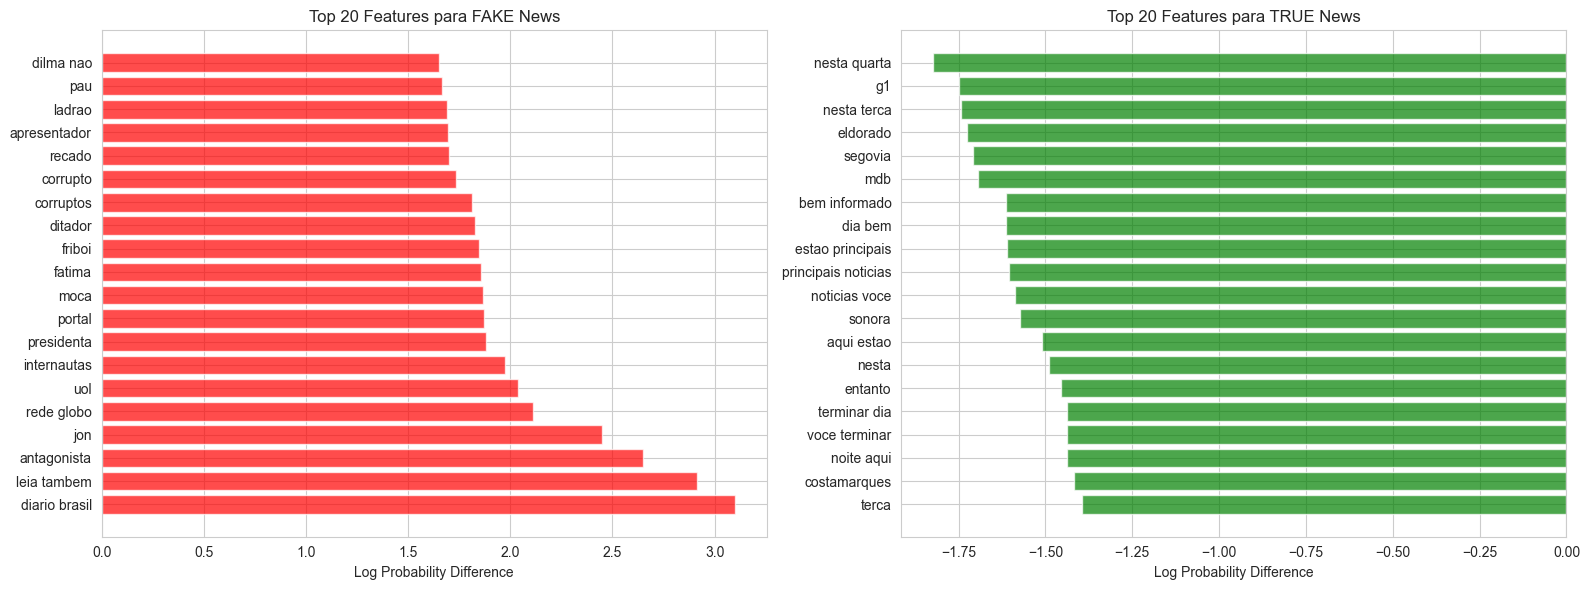

In [31]:
# Visualizar top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top features para FAKE
fake_features_df = pd.DataFrame(top_fake_features, columns=['Feature', 'Score'])
axes[0].barh(fake_features_df['Feature'], fake_features_df['Score'], color='red', alpha=0.7)
axes[0].set_title('Top 20 Features para FAKE News')
axes[0].set_xlabel('Log Probability Difference')
axes[0].invert_yaxis()

# Top features para TRUE
true_features_df = pd.DataFrame(top_true_features, columns=['Feature', 'Score'])
axes[1].barh(true_features_df['Feature'], true_features_df['Score'], color='green', alpha=0.7)
axes[1].set_title('Top 20 Features para TRUE News')
axes[1].set_xlabel('Log Probability Difference')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Curva ROC

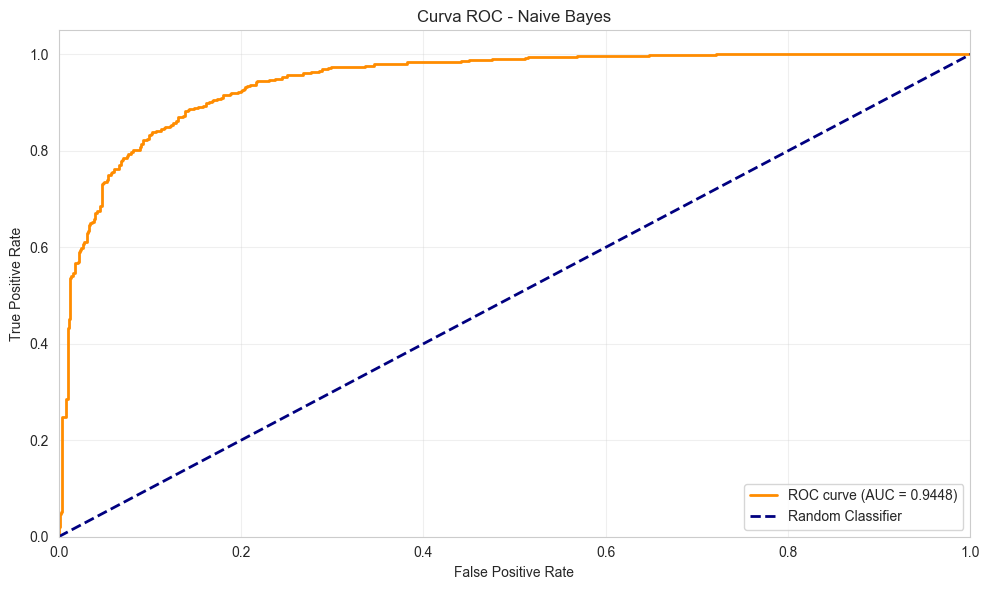

ROC AUC Score: 0.9448


In [15]:
# Calcular probabilidades
y_pred_proba = best_nb.predict_proba(X_test_tfidf)[:, 1]

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotar curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

## 8. Validação Cruzada

Executando validação cruzada (5-fold)...

F1-Scores por fold: [0.84239631 0.87725632 0.87600357 0.89315068 0.85936152]
Média: 0.8696
Desvio padrão: 0.0173


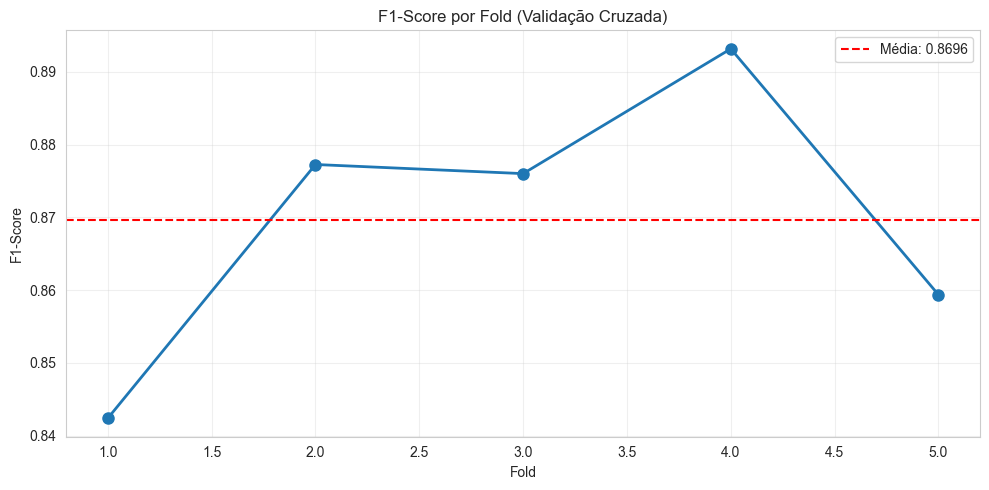

In [33]:
# Realizar validação cruzada com 5 folds
print("Executando validação cruzada (5-fold)...")
cv_scores = cross_val_score(best_nb, X_train_tfidf, y_train, cv=5, scoring='f1', n_jobs=1)

print(f"\nF1-Scores por fold: {cv_scores}")
print(f"Média: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")

# Visualizar scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Média: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score por Fold (Validação Cruzada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Salvar o Modelo

In [ ]:
import pickle
import os

# Criar diretório de modelos se não existir
os.makedirs('../models', exist_ok=True)

# Salvar modelo e vetorizador
with open('../models/naive_bayes_classifier.pkl', 'wb') as f:
    pickle.dump(best_nb, f)

with open('../models/tfidf_vectorizer_nb.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Modelo e vetorizador salvos com sucesso!")
print("- ../models/naive_bayes_classifier.pkl")
print("- ../models/tfidf_vectorizer_nb.pkl")

## 10. Teste com Exemplos

In [35]:
# Função para predizer novos textos
def predict_news(text, model, vectorizer):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    return "FAKE" if prediction == 1 else "TRUE", probability

# Testar com alguns exemplos do conjunto de teste
print("Exemplos de Predições:\n")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    text = X_test[idx]
    real_label = "FAKE" if y_test[idx] == 1 else "TRUE"
    predicted_label, proba = predict_news(text, best_nb, tfidf)
    
    print(f"Texto: {text[:100]}...")
    print(f"Real: {real_label} | Predição: {predicted_label}")
    print(f"Probabilidades - True: {proba[0]:.4f}, Fake: {proba[1]:.4f}")
    print(f"Correto: {'✓' if real_label == predicted_label else '✗'}")
    print("-" * 80)
    print()

Exemplos de Predições:

Texto: forbes: pele figura 12 atletas aposentados bem pagos mundo. . "rei futebol" aparece decima posicao, ...
Real: FAKE | Predição: FAKE
Probabilidades - True: 0.4953, Fake: 0.5047
Correto: ✓
--------------------------------------------------------------------------------

Texto: bolsonaro liberal completo, diz presidente psl partido pouca expressao nacional, psl vive momentos d...
Real: TRUE | Predição: TRUE
Probabilidades - True: 0.7785, Fake: 0.2215
Correto: ✓
--------------------------------------------------------------------------------

Texto: algo podre ar!. diario brasil publicou ontem (19) materia (original revista veja ) dizia seguinte:. ...
Real: FAKE | Predição: FAKE
Probabilidades - True: 0.0481, Fake: 0.9519
Correto: ✓
--------------------------------------------------------------------------------

Texto: delegacao australiana recusa hospedar vila olimpica prefeito ironiza: "querem canguru?". comite olim...
Real: FAKE | Predição: FAKE
Probabili

## 11. Conclusões

Este notebook implementou um classificador Naive Bayes para detectar notícias falsas.

### Principais Resultados:
- Modelo treinado com texto pré-processado
- Vetorização TF-IDF com unigramas e bigramas
- Testamos diferentes variantes (Multinomial, Complement)
- Otimização de hiperparâmetros via Grid Search
- Análise de features mais importantes
- Validação cruzada para avaliar robustez

### Vantagens do Naive Bayes:
- Rápido para treinar e fazer predições
- Funciona bem com dados de alta dimensionalidade
- Requer menos dados de treinamento que outros algoritmos
- Interpretável através das probabilidades das features
- Robusto a features irrelevantes